<a href="https://colab.research.google.com/github/rakshitgupta22/EcoSort/blob/main/Garbage_Classification_MobileNet_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow as tf
import re
from tensorflow import keras as ks

In [ ]:
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.applications import mobilenet_v2 as mobilenetv2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/drive/MyDrive/CS267Project/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

In [ ]:
os.path.exists(base_path)

True

###Create DataFrame

In [ ]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [ ]:
df.head()

,filename,category
0,plastic/plastic786.jpg,2
1,paper/paper314.jpg,0
2,metal/metal418.jpg,3
3,shoes/shoes249.jpg,6
4,biological/biological680.jpg,11


shoes/shoes1192.jpg


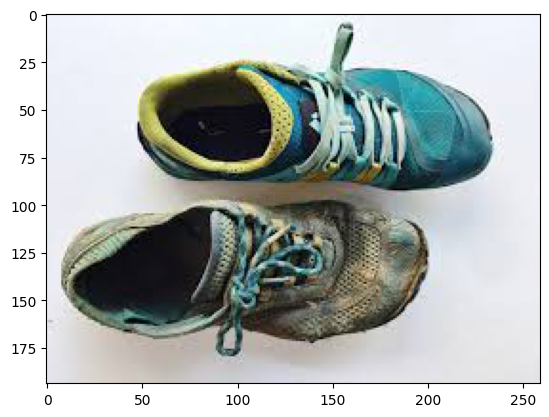

In [ ]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

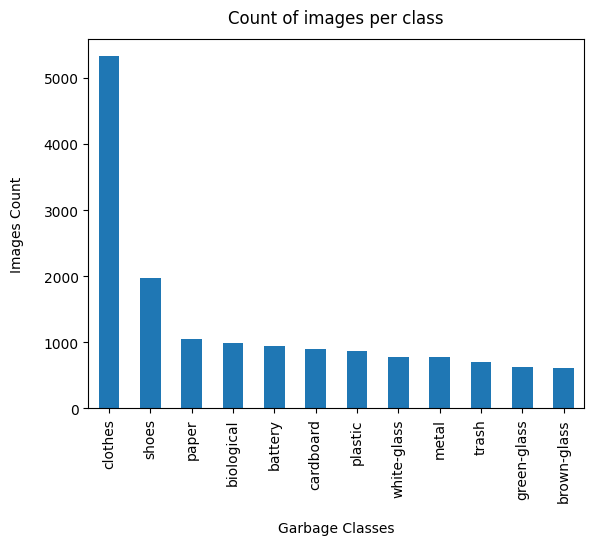

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [ ]:
df_visualization['category'].value_counts() / len(df_visualization['category']) * 100

clothes        34.321624
shoes          12.742507
paper           6.767644
biological      6.348695
battery         6.090880
cardboard       5.742830
plastic         5.575250
white-glass     4.995166
metal           4.956494
trash           4.492427
green-glass     4.054141
brown-glass     3.912343
Name: category, dtype: float64

###MobileNetV2 Transfer Learning

In [ ]:
(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)

(224, 224, 3)

In [ ]:
mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'imagenet')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False

model = Sequential()
model.add(ks.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=ks.optimizers.Adam(), metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

####Create Train, Test and Validation sets (80% 10% 10%)

In [ ]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  12412 validate size =  1551 test size =  1552


In [ ]:
batch_size=64

train_datagen = image.ImageDataGenerator(

    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2

    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [ ]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


####Train Model

In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-21-97b72bb738e0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
193/193 [==============================] - 5814s 30s/step - loss: 0.5426 - categorical_accuracy: 0.8429 - val_loss: 0.2649 - val_categorical_accuracy: 0.9284
Epoch 2/20
193/193 [==============================] - 74s 385ms/step - loss: 0.2133 - categorical_accuracy: 0.9381 - val_loss: 0.2154 - val_categorical_accuracy: 0.9368
Epoch 3/20
193/193 [==============================] - 74s 386ms/step - loss: 0.1605 - categorical_accuracy: 0.9544 - val_loss: 0.2180 - val_categorical_accuracy: 0.9401
Epoch 4/20
193/193 [==============================] - 75s 388ms/step - loss: 0.1292 - categorical_accuracy: 0.9627 - val_loss: 0.1854 - val_categorical_accuracy: 0.9473
Epoch 5/20
193/193 [==============================] - 76s 392ms/step - loss: 0.1069 - categorical_accuracy: 0.9710 - val_loss: 0.1906 - val_categorical_accuracy: 0.9440
Epoch 6/20
193/193 [==============================] - 73s 376ms/step - loss: 0.0912 - categorical_accuracy: 0.9769 - val_loss: 0.1771 - val_categorical_acc

In [ ]:
# model.save_weights("/content/drive/MyDrive/CS267Project/trained_model.h5")

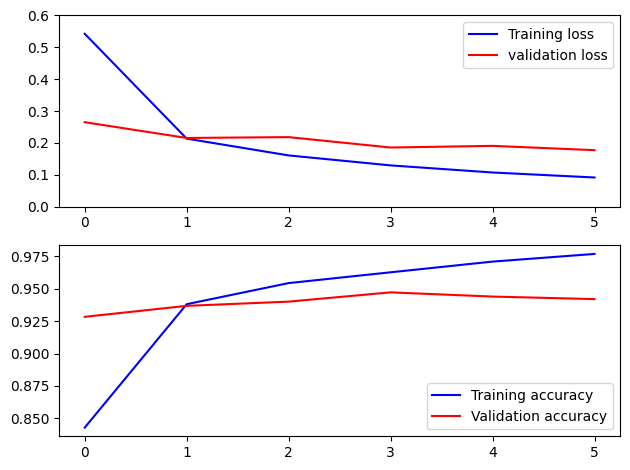

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

####Model Evaluation

In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

Found 1552 validated image filenames belonging to 12 classes.


<ipython-input-24-f40a70fea481>:18: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  93.56 % 


In [ ]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [ ]:
list(gen_label_map.values())

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [ ]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))


<ipython-input-32-2567a85855db>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.94      0.94      0.94        98
  biological       0.95      0.99      0.97       116
 brown-glass       0.85      0.93      0.89        68
   cardboard       0.95      0.91      0.93        98
     clothes       0.99      0.99      0.99       561
 green-glass       0.94      0.78      0.85        63
       metal       0.79      0.88      0.83        74
       paper       0.90      0.91      0.90       107
     plastic       0.84      0.81      0.83        70
       shoes       0.93      0.96      0.94       152
       trash       0.97      0.91      0.94        69
 white-glass       0.82      0.83      0.82        76

    accuracy                           0.94      1552
   macro avg       0.91      0.90      0.90      1552
weighted avg       0.94      0.94      0.94      1552



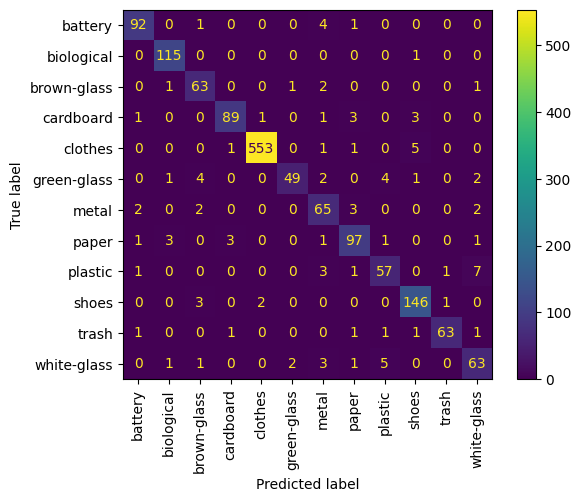

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(gen_label_map.values()), xticks_rotation = 'vertical')

In [ ]:
model.save("/content/drive/MyDrive/CS267Project/mobilenet_trained")

### Custom CNN

#### Balancing the Dataset

In [ ]:
df.category.value_counts()

7     5325
6     1977
0     1050
11     985
5      945
1      891
2      865
10     775
3      769
4      697
8      629
9      607
Name: category, dtype: int64

Selecting a baseline as 900 images for all categories. This means that we need to create 9 images for category 1, 35 for category 2, 125 for category 10, 131 for 3, 203 for 4, 271 for 8 and 293 for 9

In [ ]:
# get the count of rows in each category
counts = df['category'].value_counts()

# create an empty dataframe
new_df = pd.DataFrame(columns=df.columns)

# loop through each category
for cat in counts.index:
    # get the count of rows in the category
    count = counts[cat]

    # if count is less than 900, duplicate random rows from the original dataframe
    if count < 900:
        df_cat = df[df['category']==cat]
        n_dup = 900 - count
        dup_idx = np.random.choice(df_cat.index, n_dup, replace=True)
        dup_rows = df_cat.loc[dup_idx]
        new_df = pd.concat([new_df,dup_rows,df_cat], axis = 0)

    # if count is greater than 900, delete random rows from the original dataframe
    elif count > 900:
        df_cat = df[df['category']==cat]
        n_del = count - 900
        del_idx = np.random.choice(df_cat.index, n_del, replace=False)
        df_cat = df_cat.drop(del_idx)
        new_df = pd.concat([new_df, df_cat], axis = 0)

    # if count is equal to 900, just append the rows to the new dataframe
    else:
        df_cat = df[df['category']==cat]
        new_df = pd.concat([new_df, df_cat], axis = 0)

# shuffle the new dataframe
new_df = new_df.sample(frac=1).reset_index(drop=True)

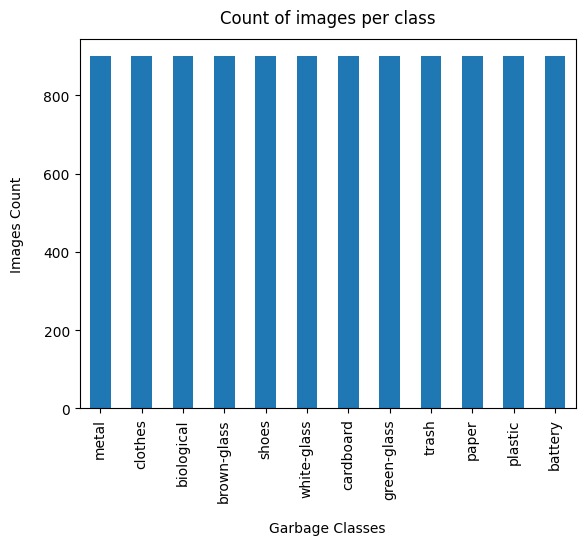

In [ ]:
df_visualization = new_df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

<function matplotlib.pyplot.show(close=None, block=None)>

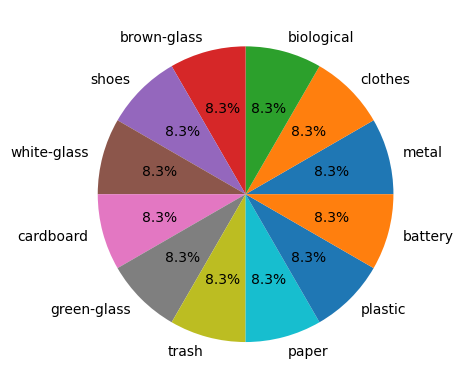

In [ ]:
df_pie = pd.DataFrame(df_visualization['category'].value_counts())

# # show plot
# plt.show()

df_pie.category.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel(None)
plt.show()

#### Creating Train Test Validation Datasets

In [ ]:
#Change the categories from numbers to names
new_df["category"] = new_df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(new_df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  8640 validate size =  1080 test size =  1080


In [ ]:
train_df.head()

,filename,category
0,brown-glass/brown-glass128.jpg,brown-glass
1,green-glass/green-glass508.jpg,green-glass
2,plastic/plastic549.jpg,plastic
3,plastic/plastic821.jpg,plastic
4,white-glass/white-glass150.jpg,white-glass


In [ ]:
batch_size=64

train_datagen = image.ImageDataGenerator(

    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2

    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=batch_size
)

Found 8640 validated image filenames belonging to 12 classes.


In [ ]:
validation_datagen = image.ImageDataGenerator(
    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2

    ##  Augmentation End  ###
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=batch_size
)

Found 1080 validated image filenames belonging to 12 classes.


In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 1080 validated image filenames belonging to 12 classes.


#### CNN Model Architecture

In [ ]:
early = EarlyStopping(monitor="val_categorical_accuracy",mode="max",patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.0001, mode = 'max')

callbacks_list = [early, learning_rate_reduction]

callbacks = callbacks_list


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = ks.Sequential([

  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(12, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=ks.optimizers.Adam(), metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                        

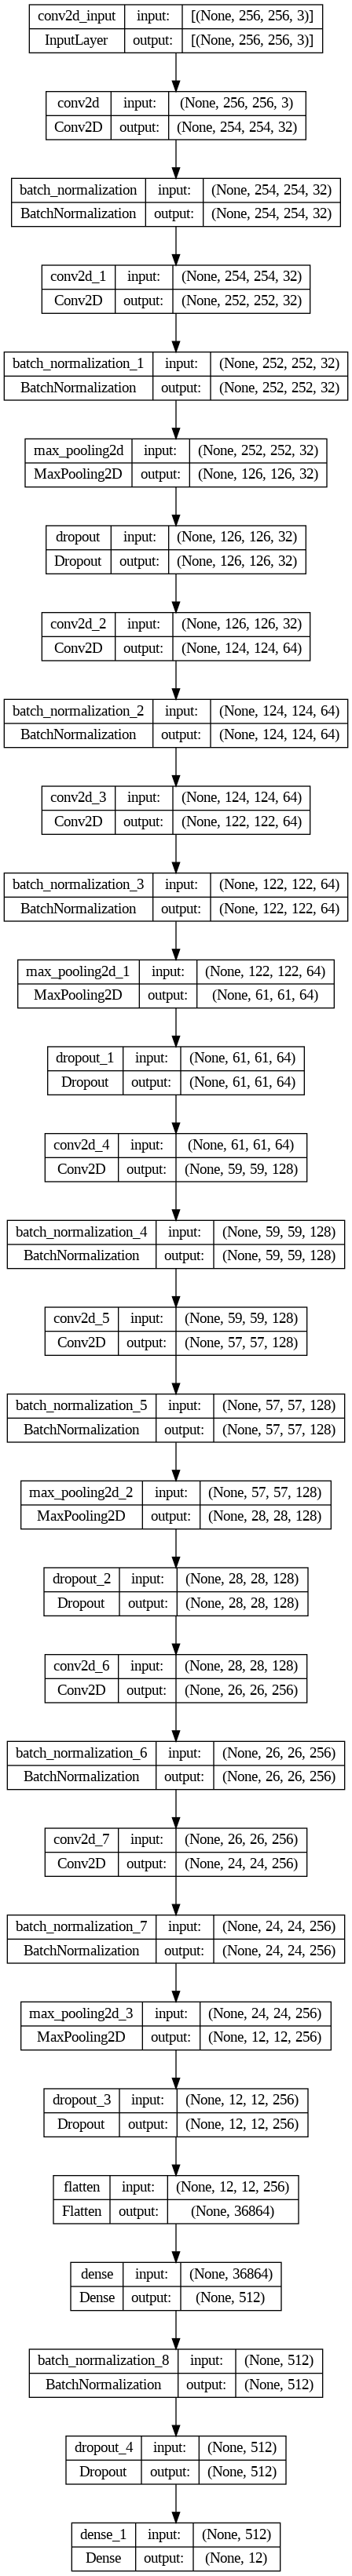

In [ ]:
tf.keras.utils.plot_model(model, to_file="/content/drive/MyDrive/CS267Project/CNN_model_arch.png", show_shapes=True)

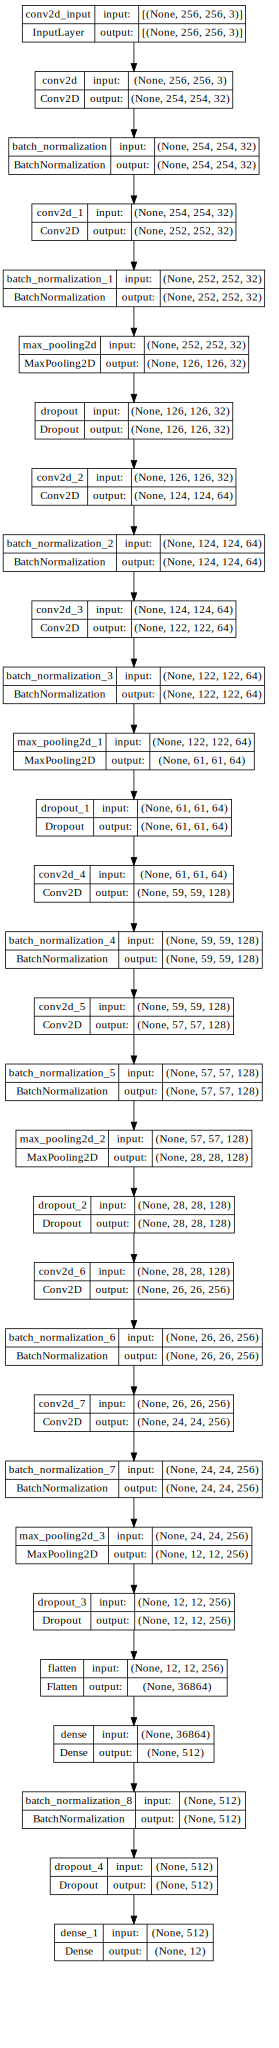

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=75).create(prog='dot', format='svg'))

In [ ]:
EPOCHS = 30
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-66-67f7f93f8029>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
135/135 [==============================] - 3822s 28s/step - loss: 1.9285 - categorical_accuracy: 0.4029 - val_loss: 2.1628 - val_categorical_accuracy: 0.4551 - lr: 0.0010
Epoch 2/30
135/135 [==============================] - 248s 2s/step - loss: 1.5068 - categorical_accuracy: 0.4978 - val_loss: 1.6361 - val_categorical_accuracy: 0.5303 - lr: 0.0010
Epoch 3/30
135/135 [==============================] - 248s 2s/step - loss: 1.3854 - categorical_accuracy: 0.5417 - val_loss: 2.2417 - val_categorical_accuracy: 0.3838 - lr: 0.0010
Epoch 4/30
135/135 [==============================] - ETA: 0s - loss: 1.2907 - categorical_accuracy: 0.5685
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
135/135 [==============================] - 249s 2s/step - loss: 1.2907 - categorical_accuracy: 0.5685 - val_loss: 1.8505 - val_categorical_accuracy: 0.4619 - lr: 0.0010
Epoch 5/30
135/135 [==============================] - 248s 2s/step - loss: 1.1194 - categorical_accuracy:

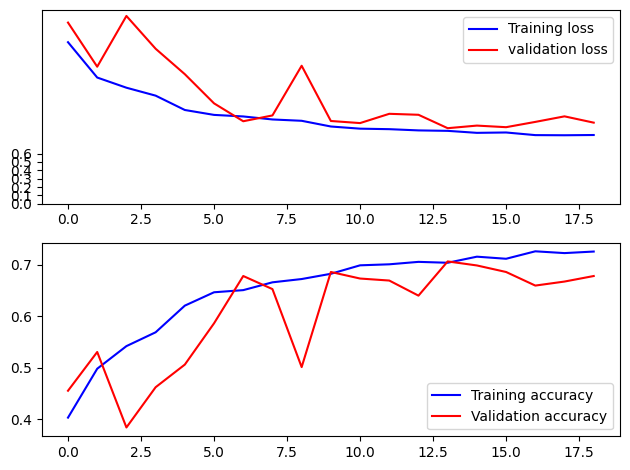

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

####Model Evaluation

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

<ipython-input-68-fa68cc8f1f4a>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  70.28 % 


In [ ]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [ ]:
list(gen_label_map.values())

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [ ]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))


<ipython-input-71-2567a85855db>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.76      0.37      0.50       100
  biological       0.70      0.89      0.78        90
 brown-glass       0.85      0.86      0.85        92
   cardboard       0.72      0.84      0.78        97
     clothes       0.63      0.85      0.72       101
 green-glass       0.86      0.96      0.91        67
       metal       0.69      0.43      0.53        76
       paper       0.64      0.73      0.68        86
     plastic       0.78      0.54      0.64       100
       shoes       0.52      0.63      0.57        91
       trash       0.80      0.71      0.75        89
 white-glass       0.63      0.68      0.66        91

    accuracy                           0.70      1080
   macro avg       0.72      0.71      0.70      1080
weighted avg       0.71      0.70      0.69      1080



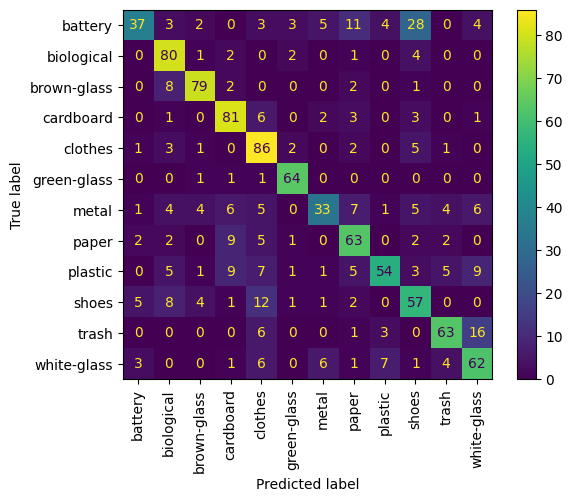

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(gen_label_map.values()), xticks_rotation = 'vertical')

In [ ]:
model.save("/content/drive/MyDrive/CS267Project/cnn_trained")

In [ ]:
model = ks.models.load_model("/content/drive/MyDrive/CS267Project/cnn_trained")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                        

In [ ]:
#Loading the saved mobile net model
model_MN = ks.models.load_model("/content/drive/MyDrive/CS267Project/mobilenet_trained")
model_MN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


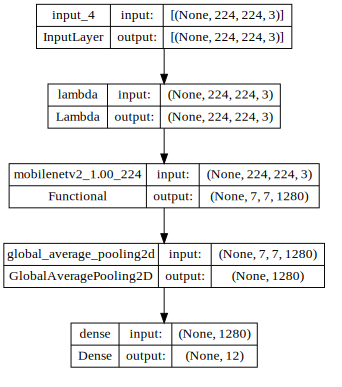

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model_MN, show_shapes=True, dpi=75).create(prog='dot', format='svg'))